In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import rfcutils
import h5py

import random
import tensorflow as tf

get_db = lambda p: 10*np.log10(p)
get_pow = lambda s: np.mean(np.abs(s)**2, axis=-1)
get_sinr = lambda s, i: get_pow(s)/get_pow(i)
get_sinr_db = lambda s, i: get_db(get_sinr(s,i))

No CUDA device found; using CPU as fallback.


2025-04-03 13:00:10.286765: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-03 13:00:10.286809: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-03 13:00:10.286815: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-03 13:00:10.286861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 13:00:10.287017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
sig_len = 40960
n_per_batch = 10
all_sinr = np.arange(-30, 0.1, 3)

seed_number = 0

## SOI Functions

In [6]:
# Function to obtain the relevant generation and demodulation function for SOI type; we will focus on QPSK and OFDMQPSK for now
def get_soi_generation_fn(soi_sig_type):
    if soi_sig_type == 'QPSK':
        generate_soi = lambda n, s_len: rfcutils.generate_qpsk_signal(n, s_len//16)
        demod_soi = rfcutils.qpsk_matched_filter_demod
    # elif soi_sig_type == 'QAM16':
    #     generate_soi = lambda n, s_len: rfcutils.generate_qam16_signal(n, s_len//16)
    #     demod_soi = rfcutils.qam16_matched_filter_demod
    # elif soi_sig_type ==  'QPSK2':
    #     generate_soi = lambda n, s_len: rfcutils.generate_qpsk2_signal(n, s_len//4)
    #     demod_soi = rfcutils.qpsk2_matched_filter_demod
    elif soi_sig_type == 'OFDMQPSK':
        generate_soi = lambda n, s_len: rfcutils.generate_ofdm_signal(n, s_len//80)
        _,_,_,RES_GRID = rfcutils.generate_ofdm_signal(1, sig_len//80)
        demod_soi = lambda s: rfcutils.ofdm_demod(s, RES_GRID)
    else:
        raise Exception("SOI Type not recognized")
    return generate_soi, demod_soi

In [7]:
soi_type = 'QPSK'
generate_soi, demod_soi = get_soi_generation_fn(soi_type) # Obtain relevant generation and demodulation function

sig1, _, true_bits1, _ = generate_soi(n_per_batch, sig_len)
bits_demod, syms_demod = demod_soi(sig1)
print('# of bits: ', bits_demod.shape)
np.allclose(bits_demod, true_bits1)

# of bits:  (100, 5120)


True

/opt/anaconda3/envs/icassp24-rf/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/opt/anaconda3/envs/icassp24-rf/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


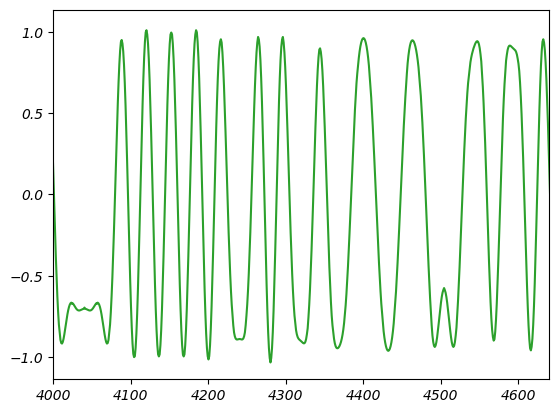

In [8]:
plt.figure()
plt.plot(sig1[0], color='tab:green')
plt.xlim([4000, 4640])
plt.show()

In [10]:
soi_type = 'OFDMQPSK'
generate_soi, demod_soi = get_soi_generation_fn(soi_type) # Obtain relevant generation and demodulation function

sig1, _, true_bits1, _ = generate_soi(n_per_batch, sig_len)
bits_demod, syms_demod = demod_soi(sig1)
print('# of bits: ', bits_demod.shape)
np.allclose(bits_demod, true_bits1)

# of bits:  (100, 57344)


False

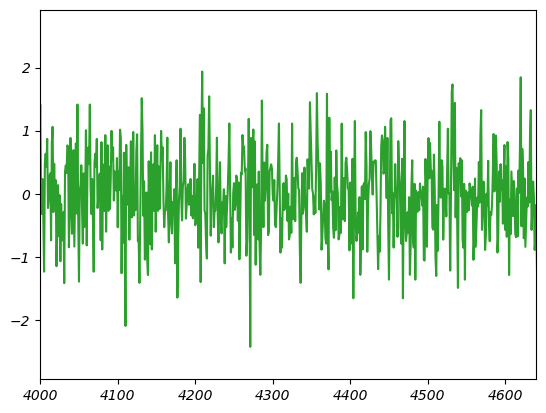

In [11]:
plt.figure()
plt.plot(sig1[0], color='tab:green')
plt.xlim([4000, 4640])
plt.show()

## Interference Functions

In [12]:
# To load the waveforms for the interference
interference_sig_type = 'CommSignal2'

with h5py.File(os.path.join('dataset', 'interferenceset_frame', interference_sig_type+'_raw_data.h5'),'r') as data_h5file:
    sig_data = np.array(data_h5file.get('dataset'))
    sig_type_info = data_h5file.get('sig_type')[()]
    if isinstance(sig_type_info, bytes):
        sig_type_info = sig_type_info.decode("utf-8") 
print(sig_type_info)

CommSignal2


/opt/anaconda3/envs/icassp24-rf/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


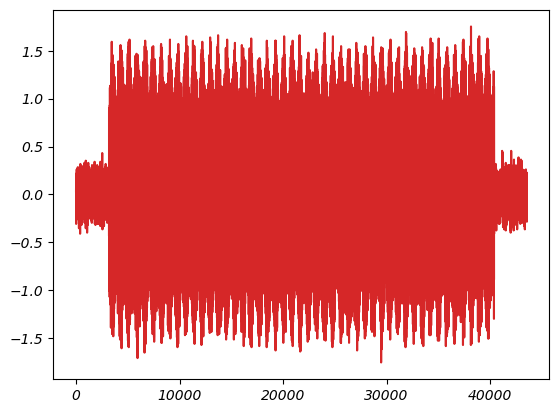

In [13]:
plt.plot(sig_data[0], color='tab:red')
plt.show()

In [11]:
# Creating 40,960-long interference signal components:

sinr = -9 # example: using -9 dB target SINR 

sig2 = sig_data[np.random.randint(sig_data.shape[0], size=(n_per_batch)), :]
rand_start_idx2 = np.random.randint(sig2.shape[1]-sig_len, size=sig2.shape[0])
inds2 = tf.cast(rand_start_idx2.reshape(-1,1) + np.arange(sig_len).reshape(1,-1), tf.int32)
sig_interference = tf.experimental.numpy.take_along_axis(sig2, inds2, axis=1)

# Interference Coefficient
rand_gain = np.sqrt(10**(-sinr/10)).astype(np.float32)
rand_phase = tf.random.uniform(shape=[sig_interference.shape[0],1])
rand_gain = tf.complex(rand_gain, tf.zeros_like(rand_gain))
rand_phase = tf.complex(rand_phase, tf.zeros_like(rand_phase))
coeff = rand_gain * tf.math.exp(1j*2*np.pi*rand_phase)

interference_components = sig_interference * coeff

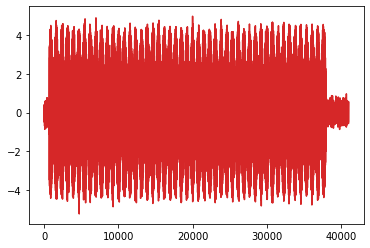

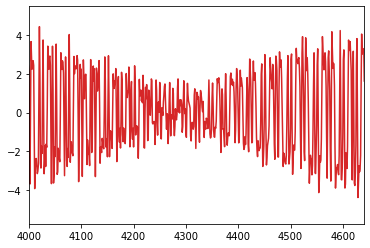

In [12]:
plt.figure()
plt.plot(interference_components[0], color='tab:red')
plt.show()

plt.figure()
plt.plot(interference_components[0], color='tab:red')
plt.xlim([4000, 4640])
plt.show()

## Creating Mixtures

In [14]:
sig_len = 40960
n_per_batch = 100
all_sinr = np.arange(-30, 0.1, 3)

soi_type, interference_sig_type = 'QPSK', 'CommSignal2'

seed_number = 0

random.seed(seed_number)
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

generate_soi, demod_soi = get_soi_generation_fn(soi_type)

with h5py.File(os.path.join('dataset', 'interferenceset_frame', interference_sig_type+'_raw_data.h5'),'r') as data_h5file:
    sig_data = np.array(data_h5file.get('dataset'))
    sig_type_info = data_h5file.get('sig_type')[()]
    if isinstance(sig_type_info, bytes):
        sig_type_info = sig_type_info.decode("utf-8") 

In [15]:
all_sig_mixture, all_sig1, all_bits1, meta_data = [], [], [], []
for idx, sinr in enumerate(all_sinr):
    sig1, _, bits1, _ = generate_soi(n_per_batch, sig_len)
    sig2 = sig_data[np.random.randint(sig_data.shape[0], size=(n_per_batch)), :]

    sig_target = sig1[:, :sig_len]

    rand_start_idx2 = np.random.randint(sig2.shape[1]-sig_len, size=sig2.shape[0])
    inds2 = tf.cast(rand_start_idx2.reshape(-1,1) + np.arange(sig_len).reshape(1,-1), tf.int32)
    sig_interference = tf.experimental.numpy.take_along_axis(sig2, inds2, axis=1)

    # Interference Coefficient
    rand_gain = np.sqrt(10**(-sinr/10)).astype(np.float32)
    rand_phase = tf.random.uniform(shape=[sig_interference.shape[0],1])
    rand_gain = tf.complex(rand_gain, tf.zeros_like(rand_gain))
    rand_phase = tf.complex(rand_phase, tf.zeros_like(rand_phase))
    coeff = rand_gain * tf.math.exp(1j*2*np.pi*rand_phase)

    sig_mixture = sig_target + sig_interference * coeff

    all_sig_mixture.append(sig_mixture)
    all_sig1.append(sig_target)
    all_bits1.append(bits1)

    actual_sinr = get_sinr_db(sig_target, sig_interference * coeff)
    meta_data.append(np.vstack(([rand_gain.numpy().real for _ in range(n_per_batch)], [sinr for _ in range(n_per_batch)], actual_sinr, [soi_type for _ in range(n_per_batch)], [interference_sig_type for _ in range(n_per_batch)])))

with tf.device('CPU'):
    all_sig_mixture = tf.concat(all_sig_mixture, axis=0).numpy()
    all_sig1 = tf.concat(all_sig1, axis=0).numpy()
    all_bits1 = tf.concat(all_bits1, axis=0).numpy()

meta_data = np.concatenate(meta_data, axis=1).T

['2.818383' '-9.0' '-9.260354' 'QPSK' 'CommSignal2']


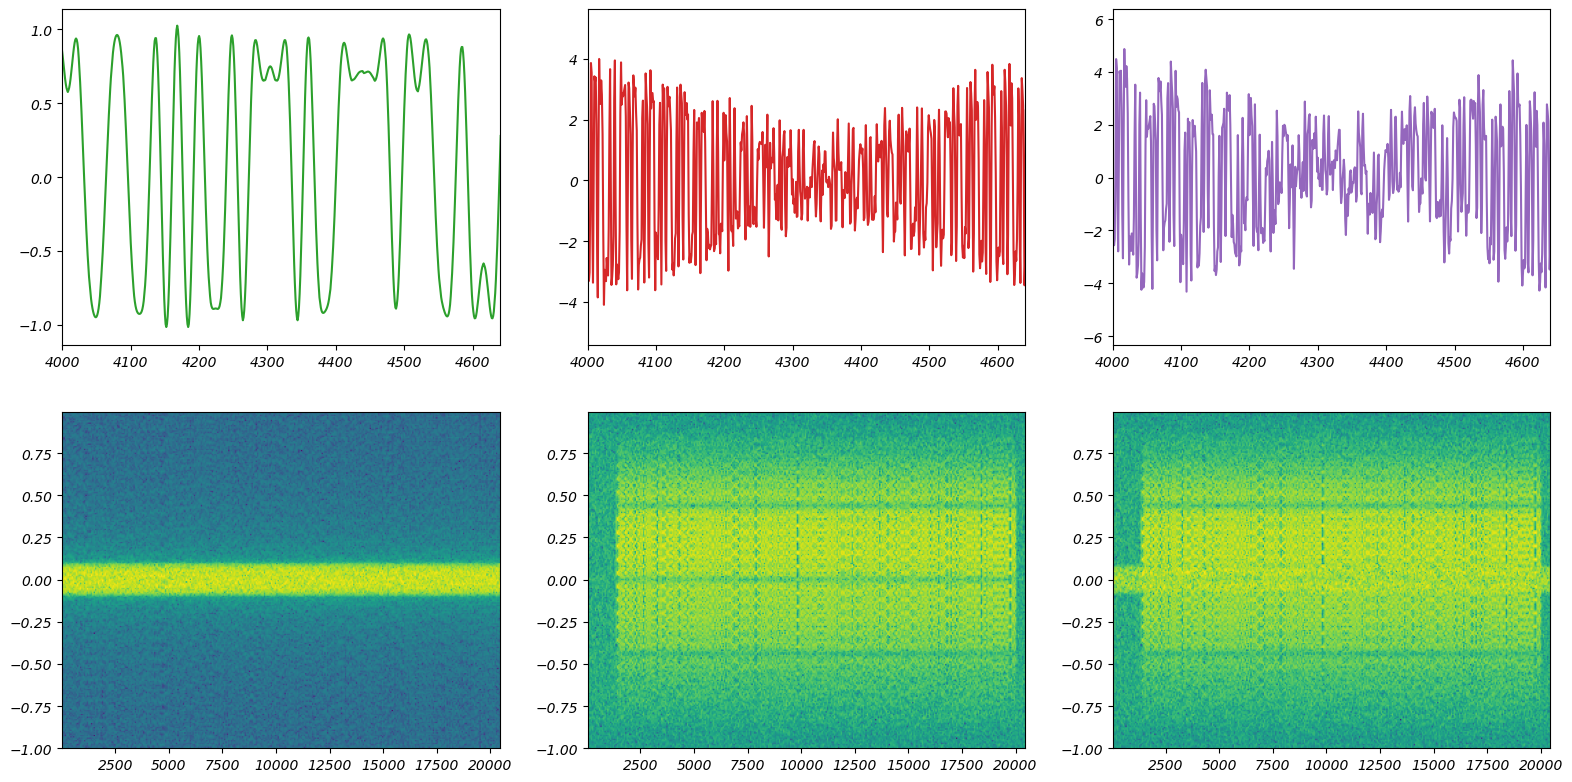

In [16]:
example_idx = 700

print(meta_data[example_idx])

plt.figure(figsize=(6.4*3, 4.8*2))
plt.subplot(231)
plt.plot(all_sig1[example_idx], color='tab:green')
plt.xlim([4000, 4640])

plt.subplot(232)
plt.plot(all_sig_mixture[example_idx]-all_sig1[example_idx], color='tab:red')
plt.xlim([4000, 4640])

plt.subplot(233)
plt.plot(all_sig_mixture[example_idx], color='tab:purple')
plt.xlim([4000, 4640])


plt.subplot(234)
plt.specgram(all_sig1[example_idx])

plt.subplot(235)
plt.specgram(all_sig_mixture[example_idx]-all_sig1[example_idx])

plt.subplot(236)
plt.specgram(all_sig_mixture[example_idx])

plt.show()

## Example Inference/Output Submission

In [16]:
testset_identifier = 'TestSet1Example'
soi_type, interference_sig_type = 'QPSK', 'CommSignal2'
all_sig_mixture = np.load(os.path.join('dataset', f'{testset_identifier}_testmixture_{soi_type}_{interference_sig_type}.npy'))
meta_data = np.load(os.path.join('dataset', f'{testset_identifier}_testmixture_{soi_type}_{interference_sig_type}_metadata.npy'))

In [17]:
n_per_batch = 100
all_sinr = np.arange(-30, 0.1, 3)

id_string = 'ExampleNoMitigation'
def run_inference(all_sig_mixture, soi_type, interference_sig_type):   
    generate_soi, demod_soi = get_soi_generation_fn(soi_type)
    
    sig1_est = all_sig_mixture # no mitigation
    
    bit_est = []
    for idx, sinr_db in enumerate(all_sinr):
        bit_est_batch, _ = demod_soi(sig1_est[idx*n_per_batch:(idx+1)*n_per_batch])
        bit_est.append(bit_est_batch)
    bit_est = tf.concat(bit_est, axis=0)
    sig1_est, bit_est = sig1_est, bit_est.numpy()
    return sig1_est, bit_est

In [18]:
sig1_est, bit1_est = run_inference(all_sig_mixture, soi_type, interference_sig_type)
np.save(os.path.join('outputs', f'{id_string}_{testset_identifier}_estimated_soi_{soi_type}_{interference_sig_type}'), sig1_est)
np.save(os.path.join('outputs', f'{id_string}_{testset_identifier}_estimated_bits_{soi_type}_{interference_sig_type}'), bit1_est)